<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/%ED%85%8C%EC%8A%A4%ED%8A%B8_%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

어떤 상태에서 특정한 액션을 취하면 리워드가 발생한다.
정책신경망에서 어떤 상태일때 액선이 산출되고 그 산출로 인한 리워드가 최대가 되도록 정책신경망의 가중치를 조정한다. 그러면 리워드가 최대가 되는 액션을 산출하는 정책신경망이 될 것이다. 

loss함수는 리워드가 최대가 되는 액션을 산출했을 때, 마이너스 무한대가 되도록 조정하면 된다. 

먼저 LSTM과 일반적 deep learning 모델을 비교해본 결과 fit 능력에서 차이는 없었다.
ㅇᆞ

In [1]:
import numpy as np
import matplotlib.pyplot as plt

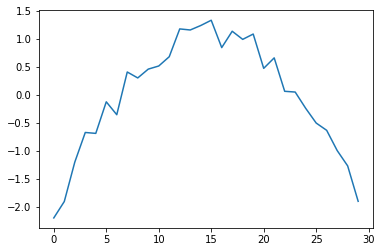

In [2]:
def env():
  price=[]
  for i in range(30):
    bias = np.random.rand(1)
    p = -0.01*(i-15)**2 + bias * 0.5
    price.append(p[0])
  p_mean = np.mean(price)
  p_std = np.std(price)
  price = (price - p_mean)/p_std
  
  p_serise= []
  for i in range(26):
    serise = [np.array(price[i]),np.array(price[i+1]), np.array(price[i+2]), np.array(price[i+3]), np.array(price[i+4])]
    serise = np.array(serise)
    p_serise.append(serise)
  p_serise= p_serise[0:25]
  p_serise = np.array(p_serise)
  #p_serise = p_serise.reshape(25, 5, 1)
  price_lstm = price[5:]
  price_lstm = np.array(price_lstm)
  return price, p_serise, price_lstm

price, p_serise, price_lstm = env()
plt.plot(price)
plt.show()

In [15]:
p_serise[0] 

array([-2.19567895, -1.90260542, -1.19901328, -0.66878054, -0.68498446])

In [4]:
from tensorflow import keras
import tensorflow as tf
import keras.layers as layers
from keras.layers import LSTM, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K  # 케라스의 backend를 K. 형식으로 호출하는 것이고 여기서는 tensorflow이다.

Using TensorFlow backend.


In [5]:
#inp_L = layers.Input(shape=(5,1),name="input_L")
#dense_L = LSTM(5, return_sequences=False)(inp_L)
inp_L = layers.Input(shape=(5,),name="input_L")
#dense_L = Dense(64)(dense_L)
dense_L = Dense(64)(inp_L)
output_L = Dense(1)(dense_L)

model_lstm = Model(inputs=inp_L, outputs = output_L)

In [6]:
model_lstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_L (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [7]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model_lstm.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [8]:
history_lstm = model_lstm.fit(p_serise, price_lstm, epochs=150, verbose=0)

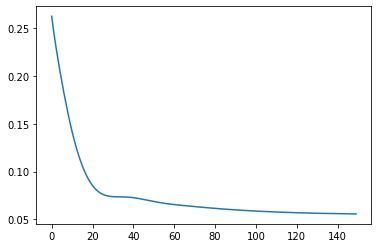

In [9]:
plt.plot(history_lstm.history['loss'])
plt.show()

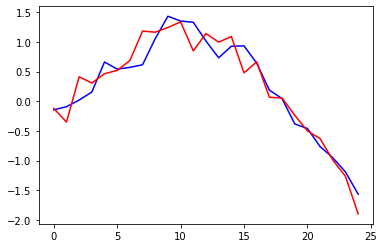

In [10]:
plt.plot(model_lstm.predict(p_serise), 'b')
plt.plot(price_lstm, 'r')
plt.show()

In [17]:
test = np.array([[-4.19567895, -2.90260542, -1.19901328, -0.66878054, -0.18498446],
[-0.19567895, -0.90260542, -1.19901328, -0.66878054, -0.18498446],
[-0.19567895, -0.90260542, -1.19901328, -2.66878054, -10.18498446],
])
a = model_lstm.predict(test)
print(a)

[[ 0.7587365]
 [-0.4001713]
 [-8.705329 ]]


In [ ]:
# 랜덤하게 행동들을 만들어낸다. 사실 이건 필요하지 않다.

def act():
  actions = []
  for i in range(30):
    if np.random.rand() > 0.5:
      act = 1
    else:
      act = 0
    actions.append(act)
  return actions

In [ ]:
y = act()

In [ ]:
y

[0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1]

In [ ]:
print(reward(price, y))

[0, -1, -2, -3, -2, -3, -2, -3, -2, -1, -2, -1, 0, 1, 0, -1, -1, -1, 0, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -3]


In [ ]:
def reward (price, action):
  reward =[0]
  
  for i in range(0, len(price)-1):
    reward_sum = 0
    price_gap = price[i+1]- price[i]
    if price_gap > 0 and action[i] == 1 :
       reward_sum = reward[i] + 1
       reward.append(reward_sum)
    if price_gap > 0 and action[i] == 0 :
       reward_sum = reward[i] -1
       reward.append(reward_sum)
    if price_gap < 0 and action[i] == 1 :
       reward_sum = reward[i] -1
       reward.append(reward_sum)
    if price_gap < 0 and action[i] == 0 :
       reward_sum = reward[i] 
       reward.append(reward_sum)
  return reward

In [ ]:
import tensorflow as tf
y_encoded = tf.keras.utils.to_categorical(y) # softmax를 사용하려면 출력 unit이 여러개이기 때문에 그것에 맞추어 y값을 변경하여야 한다.

In [ ]:
y_encoded

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

만약 정책함수에서 softmax가 행동대안을 산출하면 각 행동대안이 갖는 확률을 기반으로 하여 새로운 행동을 산출한다. 만약 각 행동대안의 확율이 높아 질 수록 산출할 행동 대안의 모습은 수렴해 갈 것이다.

In [ ]:
 def act_selection(act):
   acts = []
   for i in range(0, len(act)):
     action = np.random.choice(2,p=act[i])
     acts.append(action)
   return acts

custom loss 함수를 테스트 해본다.

In [ ]:
from tensorflow import keras
import keras.layers as layers
from keras.layers import LSTM, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K  # 케라스의 backend를 K. 형식으로 호출하는 것이고 여기서는 tensorflow이다.

Using TensorFlow backend.


In [ ]:
def my_loss(y_true, y_pred):
  y_true = y_true **2
  y_pred = y_pred **2
  loss = K.mean(K.abs(y_true - y_pred) + K.square(y_true - y_pred))
  return loss * multip


# metric는 중요하지 않다.

def my_metric(y_true, y_pred):
  return K.mean(K.abs(y_true - y_pred)) * 1000

In [ ]:
def get_policy_model(lr):
  inp = layers.Input(shape=(1,),name="input_x")
  multip = layers.Input(shape=[1], name="advantages") # [1]의 대안 (1,) 이다
  x = layers.Dense(4, activation="relu", kernel_initializer=glorot_uniform(seed=42), use_bias=False, kernel_regularizer=keras.regularizers.l2(0.001), name="dense_1")(inp)
  output = layers.Dense(2, activation="softmax",kernel_initializer=glorot_uniform(seed=42), use_bias=False, kernel_regularizer=keras.regularizers.l2(0.001), name="out")(x)
  model_train = Model(inputs=[inp, multip], outputs = output)

  # loss 함수를 actual과 predict가 같을때 -무한대가 되도록 만든다. 완전히 틀리면 0 이므로 loss 함수의 값의 범위는 -무한대 ~ 0 이다.
  def custom_loss(y_true, y_pred):
    # actual: 0 predict: 0 -> log(0 * (0 - 0) + (1 - 0) * (0 + 0)) = -inf   log(0) = - inf
    # actual: 1 predict: 1 -> log(1 * (1 - 1) + (1 - 1) * (1 + 1)) = -inf   
    # actual: 1 predict: 0 -> log(1 * (1 - 0) + (1 - 1) * (1 + 0)) = 0      log(1) = 0
    # actual: 0 predict: 1 -> log(0 * (0 - 1) + (1 - 0) * (0 + 1)) = 0
    a = y_true * (y_true - y_pred) + (1 - y_true) * (y_true + y_pred)
#    a = 0.00000000000000000000000001 + a  # 0가 입력되면 - inf가 되어 NaN 나온다. 이를 방지하기 위해서 아주 작은 수를 더해 준다.
    log_lik = K.log(a)
 #   log_lik = K.log(y_true * (y_true - y_pred) + (1 - y_true) * (y_true + y_pred))
    return K.mean(log_lik * multip, keepdims=True)

# 핵심은 loss 함수에 어떤 가중치를 곱해 준다는 것이다. 여기서는 10개의 state가 입력되어서 10개의 행동대안을 산출하는데,
# 이것이 한개의 에피소드를 구성하게 된다. 그리고 
# 10개의 입력에 대한 10개의 오류가 계산되고 각 오류에 각각의 multiple을 곱해주고 이를 다시 평균로 구한 것이 
# 각 epochs의 loss값이 된다. 


  model_train.compile(loss=custom_loss, optimizer=Adam(lr), metrics = [my_metric])
  model_predict = Model(inputs=[inp], outputs = output)
  return model_train, model_predict

In [ ]:
model_train, model_predict = get_policy_model(0.01)

In [ ]:
model_train.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_x (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4         
_________________________________________________________________
out (Dense)                  (None, 2)                 8         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 하나의 에피소드 내에서 지연된 보상을 하기 위한 방법이다. 

def discount_rewards(r, gamma=0.99):
    """Takes 1d float array of rewards and computes discounted reward
    e.g. f([1, 1, 1], 0.99) -> [2.9701, 1.99, 1]
    """
    prior = 0
    out = []
    r = r[::-1]
    for val in r:
        new_val = val + prior * gamma
        out.append(new_val)
        prior = new_val
    return np.array(out)

In [ ]:
# test_set에 적용하는 함수

def score_model(model_predict, num_tests):
    scores = []    
    for num_test in range(num_tests):
        observation = env()
        forcasts = model_predict.predict(observation)
        rw = reward(observation, np.argmax(forcasts, axis=1))
        scores.append(rw)
    return np.mean(scores)

In [ ]:

# Setting up our environment

num_actions = 2
num_episode = 0
num_episodes = 100

small_num = 0.000001

while num_episode < num_episodes:

    losses = []
    state = env() # 한개의 state를 발생시킨다.
    state = state.astype(float) # nan 발생을 막기 위한 시도이다.

    for i in range(500):
      predict = model_predict.predict(state)  # 한개의 state를 input해서 신경망을 통해 action을 만들어낸다.
      
      for i in range(0, len(predict)):     # 예측값이 극단으로 나와서 무한대가 나오지 않도록 조정한다. 시그모이드는 극단값에 오류가 날 가능성이 많다.  nan 발생을 막기 위한 시도이다
        if predict[i][0] > 0.99999:
          predict[i][0] = predict[i][0] - small_num
        if predict[i][0] < 0.00001:
          predict[i][0] = predict[i][0] + small_num
        if predict[i][1] > 0.99999:
          predict[i][1] = predict[i][1] - small_num
        if predict[i][1] < 0.00001:
          predict[i][1] = predict[i][1] + small_num
        pre_sum = predict[i][0] + predict[i][1]
        predict[i][0] = predict[i][0] / pre_sum
        predict[i][1] = predict[i][1] / pre_sum
  
      
      


      acts = []
      for i in range(0, len(predict)):
        if np.isnan(predict[i][0]) or np.isnan(predict[i][1]):
          action = np.random.choice(range(num_actions),p=[0.5, 0.5])
          acts.append(action)
        else:
          action = np.random.choice(range(num_actions),p=predict[i]) # 대안 중에서 하나를 선택한다. p=[0.4, 0.6] 대안이 선택될 확율이다. action은 0 또는 1 이된다.
          acts.append(action)

      e_r = reward(state, acts)

      if e_r[-1] > 20.0:
        break
      else:
        discounted_reward = discount_rewards(e_r)
        discounted_reward -= np.mean(discounted_reward)/np.std(discounted_reward)
        y_encoded = tf.keras.utils.to_categorical(acts)
        loss = model_train.train_on_batch([state, discounted_reward], y_encoded)
        

    losses.append(loss)
    hit = score_model(model_predict, 10)
    
    print("num_episode: ",num_episode, "loss: ", losses[-1][0], "model_reward: ", hit)

    num_episode += 1


num_episode:  0 loss:  29.628794 model_reward:  -4.34
num_episode:  1 loss:  51.812412 model_reward:  7.68
num_episode:  2 loss:  21.766575 model_reward:  7.18
num_episode:  3 loss:  49.013206 model_reward:  7.2
num_episode:  4 loss:  1.2301313 model_reward:  7.506666666666667
num_episode:  5 loss:  23.718702 model_reward:  7.28
num_episode:  6 loss:  57.959553 model_reward:  6.953333333333333
num_episode:  7 loss:  47.23328 model_reward:  7.3533333333333335
num_episode:  8 loss:  40.5295 model_reward:  7.433333333333334
num_episode:  9 loss:  107.24373 model_reward:  7.48
num_episode:  10 loss:  40.82107 model_reward:  7.846666666666667
num_episode:  11 loss:  35.067852 model_reward:  7.35
num_episode:  12 loss:  33.600254 model_reward:  1.42
num_episode:  13 loss:  -13.031285 model_reward:  -3.8066666666666666
num_episode:  14 loss:  12.904467 model_reward:  7.02
num_episode:  15 loss:  17.590446 model_reward:  6.72
num_episode:  16 loss:  -10.471379 model_reward:  7.42
num_episode: 

KeyboardInterrupt: ignored

In [ ]:
predict = model_predict.predict(state)

In [ ]:
for i in range(len(predict)):
  print(np.argmax(predict[i]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
np.log(0.0000000000000000000000000000000000000000000000000000000001)

-133.54993539365464

In [ ]:
## 여기부터 재작성

reward_sum = 0
num_actions = 2
dimen = 10
batch_size = 5

# Placeholders for our observations, outputs and rewards
states = np.empty(0).reshape(0,dimen)
actions = np.empty(0).reshape(0,dimen)
rewards = np.empty(0).reshape(0,dimen)
discounted_rewards = np.empty(0).reshape(0,dimen)

# Setting up our environment
state = env() # 한개의 state를 발생시킨다.

num_episode = 0
num_episodes = 500

losses = []

while num_episode < num_episodes:
    
    predict = model_predict.predict(state)  # 한개의 state를 input해서 신경망을 통해 action을 만들어낸다.
    
    #print(predict)

    acts = []
    for i in range(0, len(predict)):
      action = np.random.choice(range(num_actions),p=predict[i]) # 대안 중에서 하나를 선택한다. p=[0.4, 0.6] 대안이 선택될 확율이다. action은 0 또는 1 이된다.
      acts.append(action)

    #print(acts)

    e_r = reward(state, acts)



    # Append the observations and outputs for learning
    states = np.vstack([states, state]) # 미리 만들어 놓은 placeholder인 states에 while문 밖에서 만들어낸 state를 append 시키다.
    actions = np.vstack([actions, acts]) # 동일하게 state가 입력이 되어서 신경망이 산출한 행동을 확율적으로 선택한 행동을 actions에 append한다.

    #print(actions)

    rewards = np.vstack([rewards, e_r])

    #print(rewards)

    if np.sum(e_r) > 8 or len(states) >= 20:
      # Determine standardized rewards
      for i in range(0, len(rewards)-1):
        discounted_rewards_episode = discount_rewards(rewards[i], gamma=0.99)
        discounted_rewards = np.vstack([discounted_rewards, discounted_rewards_episode])

      

      for i in range(0, len(discounted_rewards)-1):  
        discounted_rewards[i] -= discounted_rewards[i].mean()
        discounted_rewards[i] /= discounted_rewards[i].std()
        discounted_rewards = discounted_rewards.squeeze()

            
      actions = actions.squeeze().astype(int)  # squeeze 함수는 배열에서 차원이 1인 것을 찾아서 없애버린다. 예) (2,2,1) --> (2,2)
   

      y_target = []
      for i in range(0, len(actions)-1):
        actions_train = np.zeros([len(actions[i]), num_actions])
        actions_train[np.arange(len(actions[i])), actions[i]] = 1
        y_target.append(actions_train)



      for i in range(0, len(states)-1):
        loss = model_train.train_on_batch([states[i], discounted_rewards[i]], y_target[i])
        losses.append(loss)
        hit = score_model(model_predict, 100)

      print(losses, "score is:", hit)

      #hit = score_model(model_predict, 100)
      #print(hit)

            
      states = np.empty(0).reshape(0,dimen)
      actions = np.empty(0).reshape(0,dimen)
      rewards = np.empty(0).reshape(0,dimen)
      discounted_rewards = np.empty(0).reshape(0,dimen)

    num_episode += 1


[[-0.17134354, 424.02673], [-0.17666495, 402.87653], [-0.17286736, 473.20026], [-0.20000513, 425.26587], [-0.4921371, 447.9498]] score is: 3.54
[[-0.17134354, 424.02673], [-0.17666495, 402.87653], [-0.17286736, 473.20026], [-0.20000513, 425.26587], [-0.4921371, 447.9498], [-0.08437457, 480.33896], [-0.012353575, 484.61636], [0.006205964, 560.36475], [-0.19773993, 422.5599], [0.005452824, 413.22583], [-0.10748787, 452.38953], [-0.10706987, 464.27267], [-0.22374515, 433.20386], [-0.123715356, 413.9975], [-0.03620839, 423.74664], [-0.15655065, 474.16736], [-0.09205987, 481.48737], [-0.2051022, 389.10062], [-0.11515021, 530.37274], [-0.22005029, 420.79654], [-0.21384712, 409.01703], [-0.15261897, 465.4117], [-0.19413432, 406.67566], [-0.35986453, 434.7005]] score is: 3.82
[[-0.17134354, 424.02673], [-0.17666495, 402.87653], [-0.17286736, 473.20026], [-0.20000513, 425.26587], [-0.4921371, 447.9498], [-0.08437457, 480.33896], [-0.012353575, 484.61636], [0.006205964, 560.36475], [-0.19773993,

KeyboardInterrupt: ignored

In [ ]:


        # Print periodically
        if (num_episode + 1) % print_every == 0:
            # Print status
            score = score_model(model_predict,10)
            print("Average reward for training episode {}: {:0.2f} Test Score: {:0.2f} Loss: {:0.6f} ".format(
                (num_episode + 1), reward_sum/print_every, 
                score,
                np.mean(losses[-print_every:])))
            
            if score >= goal:
                print("Solved in {} episodes!".format(num_episode))
                break
            reward_sum = 0
                
        num_episode += 1
        observation = env.reset()

In [ ]:
[1,2,3].mean()

AttributeError: ignored

In [ ]:
states = np.empty(0).reshape(0,10)
observation = env()
state = observation
states = np.vstack([states, state])
print(states)

[[-2.14444758 -0.44786527  0.27428755 -1.35549211  0.21041568  0.58894521
   0.73969842  0.03003539  1.31171488  0.79270784]]


In [ ]:
states

array([[-2.14444758, -0.44786527,  0.27428755, -1.35549211,  0.21041568,
         0.58894521,  0.73969842,  0.03003539,  1.31171488,  0.79270784]])

In [ ]:
acts=[]
for i in range(0, len(f)):
  action = np.random.choice(range(2),p=f[i]) # 대안 중에서 하나를 선택한다. p=[0.4, 0.6] 대안이 선택될 확율이다. action은 0 또는 1 이된다.
  acts.append(action) 

In [ ]:
acts

[0, 1, 0, 0, 1, 1, 1, 0, 1, 0]

In [ ]:
actions = np.empty(0).reshape(0,dimen)

In [ ]:
actions = np.vstack([actions, acts])

In [ ]:
actions

array([[0., 1., 0., 0., 1., 1., 1., 0., 1., 0.]])

In [ ]:
actions = actions.squeeze().astype(int)

In [ ]:
actions

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 0])

In [ ]:
actions_train = np.zeros([len(actions), 2])


In [ ]:
actions_train

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [ ]:
actions_train[np.arange(len(actions)), actions] = 1

In [ ]:
actions_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [ ]:
for i in range(len(states)):
  print(reward(states[i], actions[i]))

[-1, 1, -1, 1, 1, 1, 1, -1, -1]


In [ ]:
len(actions)

1

In [ ]:
action = np.argmax(forcasts, axis=1)

In [ ]:
action

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
price

array([-1.33860938, -0.87349678, -1.77357356, -0.08613236,  0.42536386,
        0.59313445,  0.52425265, -0.10512848,  1.36200137,  1.27218823])

In [ ]:
for i in range(0, len(price)-1):
  print(price[i], action[i])

-1.338609382765694 0
-0.873496776229333 0
-1.7735735604440708 0
-0.0861323574778538 0
0.4253638642884277 0
0.5931344497708159 0
0.5242526478853675 0
-0.10512848167939567 0
1.36200137023465 0


In [ ]:
multip.shape

(10,)

여기까지가 커스텀 손실함수 이다.

10일씩 발생한 상황을 기준으로 액션결과를 바탕으로 스코어링을 한다고 가정하자.

In [ ]:
  best_score = np.argmax(reward_set)
  best_action = action_set[best_score]

In [ ]:
best_score

88083

In [ ]:
best_action[0]

1

In [ ]:
np.mean(test_score)

6.606158632153271